# Numerical Integration
MIT 6.728: Applied Quantum and Statistical Physics

Shoumik Chowdhury (@shoumikc). Oct. 29, 2021.

## Imports + Setup

In [2]:
%load_ext autoreload
%autoreload 2

In [222]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit
from NewtonFDSE import SystemSolver, plot_error, plot_error_log, plot_wavefunction

## Initialize Simulation: ${\rm v}(y) = y^4$

We want to solve the dimensionless Schrodinger Eq. $$ \epsilon \psi(y) = -\frac{\partial^2}{\partial y^2} \psi(y) + y^4\psi(y)$$
to compute the ground state energy $\epsilon_0$ and wavefunction $\phi_0(y)$. In this problem, we will do so using a so-called finite basis approximation with ansatz $$\psi_t(y) = \sum_{n=1}^N c_n u_n(y)$$ where the basis states are given by $$u_n(y) = \frac{1}{\sqrt{y_{\rm max}}} \,\cos\left(\frac{(2n-1)\pi y}{2y_{\rm max}}\right)$$ for $-y_{\rm max} < y < y_{\rm max}$ and zero otherwise.

In [135]:
"""Define 1D potential v(y)"""
v = lambda y: y**4

"""Set parameters and initialize solver"""
N = 200

params = {
    "N": N,
    "ymax": 5,
    "tol": 1e-10,
    "ε_range": [1.0, 1.1],
    "verbose": True,
    "use_noumerov": False
}

sys = SystemSolver(params, potential=v)

"""Extract grid properties"""
ymax = sys.params["ymax"]
grid = sys.grid
h = sys.h

In [136]:
def u(n: int, y: float, ymax: float = 5):
    """
    Trial basis state u_n(y)
    """
    if ymax <= 0:
        raise ValueError("Please use a positive value for the grid size ymax!")
    
    if np.abs(y) > np.abs(ymax):
        return 0
    else:
        return np.cos((2*n - 1)*np.pi*y / (2*ymax)) * np.sqrt(1/ymax)

In [137]:
def getMatrixElement_V(n: int, m: int, grid: np.ndarray):
    """
    Function to compute potential energy (V) matrix element 
    (u_n | V(y) |u_m) via numerical integration. 
    """
    
    mel = 0
    for y in grid:
        mel += v(y) * u(n, y) * u(m, y)
    
    mel *= h
    
    return mel

def getMatrixElement_T(n: int, m: int, grid: np.ndarray):
    """
    Function to compute kinetic energy (T) matrix element 
    (u_n | [-d²/dy²] |u_m) via analytic result. 
    """
    ymax = grid[-1]
    π = np.pi
    
    if m == n:
        return (π*(2*n - 1) / (4*ymax**2)) * ((2*n - 1)*π - np.sin(2*n*π))
    else:
        return (π*(2*m - 1)**2 / (4*ymax**2)) * (np.sin((m-n)*π) / (m-n) + np.sin((m+n-1)*π) / (m+n-1))

In [138]:
"""Compare numerical integration to analytic result for H12"""
numerical = getMatrixElement_V(1, 2, grid)
analytical = -3*(2*np.pi**2 - 15) * (ymax**4) / (2*np.pi**4)

print(f" Numerical: {numerical}\n Analytical: {analytical}")

 Numerical: -45.61184368011266
 Analytical: -45.611843872884855


## Finite Basis Calculations

In [139]:
"""Define 1D potential v(y)"""
v = lambda y: y**4

"""Set parameters and initialize solver"""
N = 500

params = {
    "N": N,
    "ymax": 5,
    "tol": 1e-10,
    "ε_range": [1.0, 1.1],
    "verbose": True,
    "use_noumerov": False
}

sys = SystemSolver(params, potential=v)

"""Extract grid properties"""
ymax = sys.params["ymax"]
grid = sys.grid
h = sys.h

In [129]:
bases = [3, 4, 5, 10, 15, 20]
E0_values = []

for BasisSize in tqdm(bases):
    H = np.zeros([BasisSize, BasisSize])

    for i in range(BasisSize):
        for j in range(BasisSize):
            H[i, j] += getMatrixElement_T(i + 1, j + 1, grid) + getMatrixElement_V(i + 1, j + 1, grid)
    
    E0 = np.min(np.linalg.eigvals(H))
    E0_values.append(E0)

100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


In [507]:
print(E0_values)

[1.5145793249418715, 1.0999921735314324, 1.064386991308841, 1.0603631205904502, 1.0603620904871829, 1.0603620904841806]


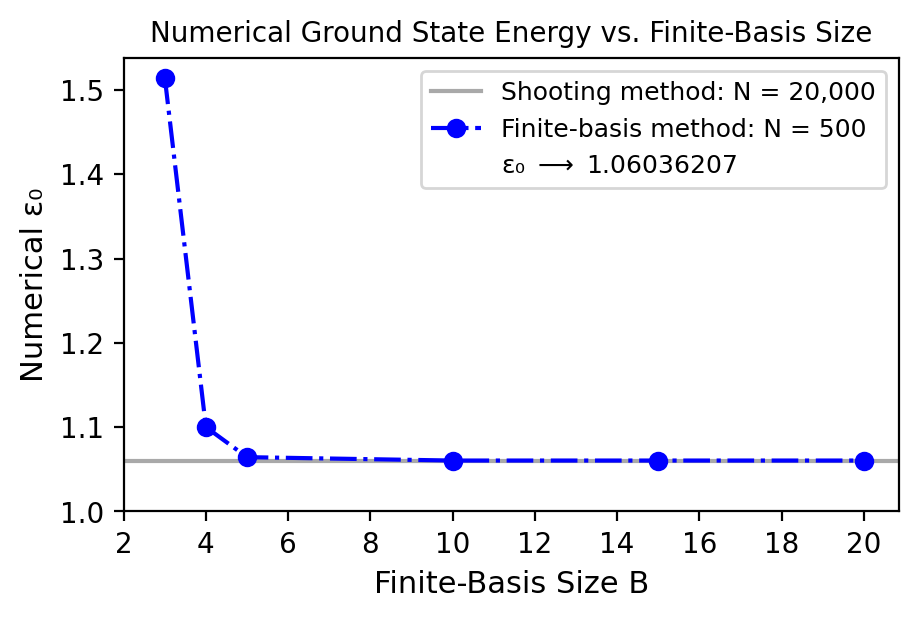

In [323]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
plt.axhline(1.06036207, linestyle='-', color='darkgrey', label="Shooting method: N = 20,000")
ax.plot(bases, E0_values, linestyle='-.', marker='o', color='b', label="Finite-basis method: N = 500")
plt.plot([], [], '', color='white', label=r"ε₀ $\longrightarrow$ 1.06036207")
ax.set_xlabel("Finite-Basis Size B", fontsize=11)
plt.xticks(range(2, 21, 2))
plt.yticks(np.arange(1, 1.51, 0.1)) 
ax.set_ylabel("Numerical ε₀", fontsize=11)
ax.set_title(f"Numerical Ground State Energy vs. Finite-Basis Size", fontsize=10)
plt.legend(fontsize=9)

In [463]:
"""Pull out the results for N = 20"""
assert np.shape(H) == (20, 20)

# Since H is hermitian, we can use eigh here!
eigvals = np.linalg.eigh(H)[0]
eigvecs = np.linalg.eigh(H)[1].T

In [464]:
MinIdx = np.argmin(eigvals)
E0 = eigvals[MinIdx]
c0 = eigvecs[MinIdx]

In [467]:
cRange = range(len(c0))
ψ0 = [np.sum([c0[n] * u(n+1, y) for n in cRange]) for y in grid]

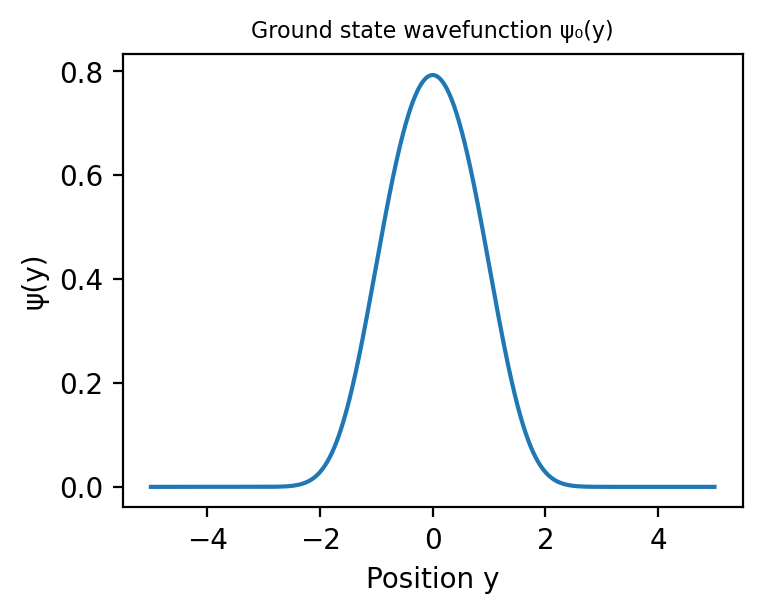

In [471]:
plot_wavefunction(grid, ψ0, title="Ground state wavefunction ψ₀(y)")

## Compare to Shooting Newton

In [491]:
"""Define 1D potential v(y)"""
v = lambda y: y**4

"""Set parameters and initialize solver"""
N = 20000

params = {
    "N": N,
    "ymax": 5,
    "tol": 1e-10,
    "ε_range": [1.0, 1.1],
    "verbose": False,
    "use_noumerov": True
}

sys2 = SystemSolver(params, potential=v)
NewtonGrid = sys2.grid

In [492]:
ψNewton, εNewton = sys2.shootingNewton()

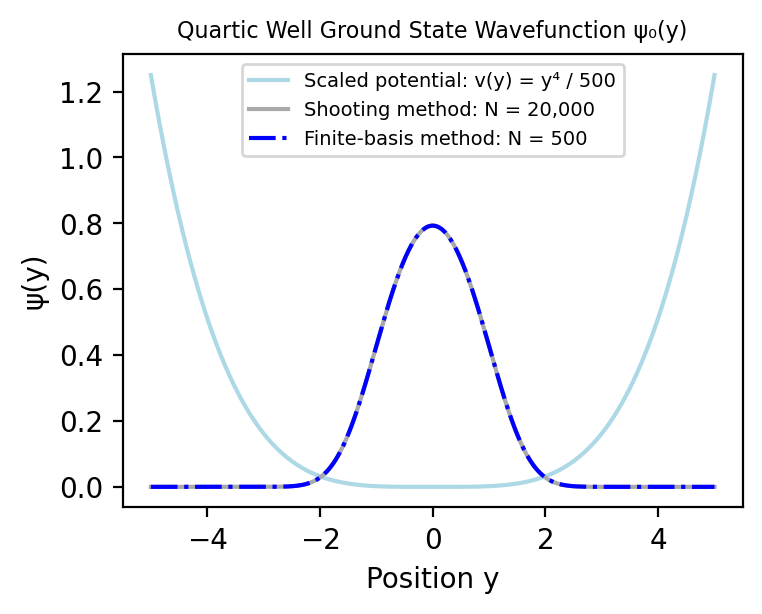

In [501]:
""" Plot Wavefunctions"""

fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
ax.plot(grid, v(grid)/500, 'lightblue', label="Scaled potential: v(y) = y⁴ / 500")
ax.plot(NewtonGrid, ψNewton, 'darkgrey', label="Shooting method: N = 20,000")
ax.plot(grid, ψ0, 'b-.', label="Finite-basis method: N = 500")
ax.set_xlabel("Position y")
ax.set_ylabel("ψ(y)")
ax.set_title(f"Quartic Well Ground State Wavefunction ψ₀(y)", fontsize=8)
ax.legend(fontsize=7)